In [1]:
!pip install --no-index /kaggle/input/imc2024-packages-lightglue-rerun-kornia/* --no-deps
!mkdir -p /root/.cache/torch/hub/checkpoints
!cp /kaggle/input/aliked/pytorch/aliked-n16/1/aliked-n16.pth /root/.cache/torch/hub/checkpoints/
!cp /kaggle/input/lightglue/pytorch/aliked/1/aliked_lightglue.pth /root/.cache/torch/hub/checkpoints/
!cp /kaggle/input/lightglue/pytorch/aliked/1/aliked_lightglue.pth /root/.cache/torch/hub/checkpoints/aliked_lightglue_v0-1_arxiv-pth
!pip install -U /kaggle/input/faiss-gpu-173-python310/faiss_gpu-1.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Processing /kaggle/input/imc2024-packages-lightglue-rerun-kornia/kornia-0.7.2-py2.py3-none-any.whl
Processing /kaggle/input/imc2024-packages-lightglue-rerun-kornia/kornia_moons-0.2.9-py3-none-any.whl
Processing /kaggle/input/imc2024-packages-lightglue-rerun-kornia/kornia_rs-0.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /kaggle/input/imc2024-packages-lightglue-rerun-kornia/lightglue-0.0-py3-none-any.whl
Processing /kaggle/input/imc2024-packages-lightglue-rerun-kornia/pycolmap-0.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /kaggle/input/imc2024-packages-lightglue-rerun-kornia/rerun_sdk-0.15.0a2-cp38-abi3-manylinux_2_31_x86_64.whl
  Attempting uninstall: kornia-rs
    Found existing installation: kornia_rs 0.1.8
    Uninstalling kornia_rs-0.1.8:
      Successfully uninstalled kornia_rs-0.1.8
  Attempting uninstall: kornia
    Found existing installation: kornia 0.8.0
    Uninstalling kornia-0.8.0:
      Successfully uninstalled ko

In [3]:
!pip install umap-learn
!pip install hdbscan

In [5]:
import torch
import torch.nn.functional as F
import kornia as K
import kornia.feature as KF
import h5py
import dataclasses
from IPython.display import clear_output
from collections import defaultdict
from copy import deepcopy
from lightglue import match_pair
from lightglue import ALIKED, LightGlue
from lightglue.utils import load_image, rbd
from transformers import AutoImageProcessor, AutoModel
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import os
import cv2 as cv
from tqdm import tqdm
from time import time, sleep
import umap
from hdbscan import HDBSCAN
import gc
import pandas as pd
import numpy as np
import faiss

import pycolmap
import sys
sys.path.append('/kaggle/input/imc25-utils')
from database import *
from h5_to_db import *
import metric

In [6]:
device = K.utils.get_cuda_device_if_available(0)
print(f'{device=}')

device=device(type='cuda', index=0)


In [7]:
data_dir = "/kaggle/input/image-matching-challenge-2025"
train_labels = pd.read_csv(f"{data_dir}/train_labels.csv")
train_labels

,dataset,scene,image,rotation_matrix,translation_vector
0,imc2023_haiper,fountain,fountain_image_116.png,0.122655949;0.947713775;-0.294608417;0.1226706...,0.093771314;-0.803560988;2.062001533
1,imc2023_haiper,fountain,fountain_image_108.png,0.474305910;0.359108654;-0.803787832;0.2888416...,0.358946647;-0.797557548;1.910906929
2,imc2023_haiper,fountain,fountain_image_101.png,0.565115476;-0.138485064;-0.813305838;0.506678...,0.146922468;-0.981392596;2.009002852
3,imc2023_haiper,fountain,fountain_image_082.png,-0.308320392;-0.794654112;0.522937261;0.948141...,0.206413831;-1.174321103;3.667167680
4,imc2023_haiper,fountain,fountain_image_071.png,-0.569002830;-0.103808175;0.815757098;0.778745...,-0.015140892;-1.334052012;3.488936597
...,...,...,...,...,...
1940,stairs,stairs_split_2,stairs_split_2_1710453733751.png,0.961762441;-0.187990401;0.199179859;-0.177691...,-0.112850000;-3.521750000;-2.859750000
1941,stairs,stairs_split_2,stairs_split_2_1710453759963.png,0.237960308;0.580896704;-0.778417569;0.4077886...,-0.490768000;-3.064140000;3.008420000
1942,stairs,stairs_split_2,stairs_split_2_1710453805788.png,0.309067298;0.541767194;-0.781642957;0.4038963...,-0.572757000;0.885835000;4.987270000
1943,stairs,stairs_split_2,stairs_split_2_1710453765165.png,0.301920210;0.609614467;-0.732949103;0.5007116...,-0.135613000;-1.832910000;1.598790000


In [11]:
def kmeans(X, cluster_num):
    print("Perform K-means clustering...")
    d = X.shape[1]
    X = X.astype(np.float32)
    kmeans = faiss.Kmeans(d, cluster_num, gpu=True, spherical=True, niter=300, nredo=10)
    kmeans.train(X)
    D, I = kmeans.index.search(X, 1)
    I = I.reshape(-1)
    print("K-means clustering done.")
    return I
    
def get_image_embeddings(image_paths, clip_model, processor, device):
    batch_size = 2048
    num_images = len(image_paths)
    features = []
    for i in range(num_images // batch_size + 1):
        start = i * batch_size
        end = start + batch_size
        if end > num_images:
            end = num_images
        images_batch = []
        for image_path in image_paths[start:end]:
            images_batch.append(Image.open(image_path))  

        with torch.no_grad():
            inputs = processor(images=images_batch, return_tensors="pt", padding=True).to(device)
            feature = clip_model.get_image_features(**inputs)
            features.append(feature)

        if i % 50 == 0:
            print(f"[Completed {i * batch_size}/{num_images}]")
            
    features = torch.cat(features)
    return features

def construct_text_counterparts(samples, device, is_train=True):
    # Load Pretrained CLIP
    model_name = "openai/clip-vit-base-patch32"
    clip_model = CLIPModel.from_pretrained(model_name).to(device)
    processor = CLIPProcessor.from_pretrained(model_name)
    clip_model.eval()

    # Get image paths from all datasets
    image_paths = []
    for dataset, predictions in samples.items():
        images_dir = os.path.join(data_dir, 'train' if is_train else 'test', dataset)
        paths = [os.path.join(images_dir, p.filename) for p in predictions]
        image_paths.extend(paths)

    def get_text_embeddings():
        nouns = pd.read_csv(f"/kaggle/input/wordnetnouns/WordNetNouns.csv").values
        nouns_num = nouns.shape[0]
        batch_size = 2048
        features = []
        for i in range(nouns_num // batch_size + 1):
            start = i * batch_size
            end = start + batch_size
            if end > nouns_num:
                end = nouns_num
            nouns_batch = nouns[start:end]
            with torch.no_grad():
                prompt = [f"a photo of a {word}" for word in nouns_batch[:, 0]]
                text = processor(text=prompt, return_tensors="pt", padding=True, truncation=True).to(device)
                feature = clip_model.get_text_features(**text)
                features.append(feature)
            if i % 50 == 0:
                print(f"[Completed {i * batch_size}/{nouns_num}]")
        features = torch.cat(features)
        return features

    # Get text embeddings using CLIP
    text_embeddings = get_text_embeddings()
    
    # Get image embeddings using CLIP
    image_embeddings = get_image_embeddings(image_paths, clip_model, processor, device)

    # Normalize embeddings
    text_embeddings = text_embeddings / text_embeddings.norm(dim=1, keepdim=True)
    image_embeddings = image_embeddings / image_embeddings.norm(dim=1, keepdim=True)

    text_embeddings = text_embeddings.half()
    image_embeddings = image_embeddings.half()

    n_nouns = text_embeddings.shape[0]
    n_images = image_embeddings.shape[0]
    
    # Find cluster_num semantic clusters in image embeddings based on text embeddings
    cluster_num = min(1, max(10, n_images//10))
    preds = kmeans(image_embeddings.cpu().numpy(), cluster_num)

    image_centers = torch.zeros((cluster_num, 512), dtype=torch.float16).cuda()
    for k in range(cluster_num):
        image_centers[k] = image_embeddings[preds == k].mean(dim=0)
    image_centers = F.normalize(image_centers, dim=1)

    # Match nouns to image centers
    similarity = torch.matmul(image_centers, text_embeddings.T)
    softmax_nouns = torch.softmax(similarity, dim=0).cpu().float()
    class_pred = torch.argmax(softmax_nouns, dim=0).long()

    # Identify highly distinguishable nouns by choosing topK most confident nouns for each image cluster
    topK = 5
    selected_idx = torch.zeros_like(class_pred, dtype=torch.bool)
    for k in range(cluster_num):
        if (class_pred == k).sum() == 0:
            continue
        class_index = torch.where(class_pred == k)[0]
        softmax_class = softmax_nouns[:, class_index]
        confidence = softmax_class.max(dim=0)[0]
        rank = torch.argsort(confidence, descending=True)
        selected_idx[class_index[rank[:topK]]] = True
    selected_idx = selected_idx.cpu().numpy()

    print(selected_idx.sum(), "nouns selected.")
    text_embeddings_selected = text_embeddings[selected_idx]

    # Use selected nouns for zero-shot classification
    tau = 0.005
    retrieval_embeddings = []
    batch_size = 8192
    for i in range(n_images // batch_size + 1):
        start = i * batch_size
        end = start + batch_size
        if end > n_images:
            end = n_images
            images_batch = image_embeddings[start:end]
        similarity = torch.matmul(image_embeddings[start:end], text_embeddings_selected.T)
        similarity = torch.softmax(similarity / tau, dim=1)
        retrieval_embedding = (similarity @ text_embeddings_selected).cpu()
        retrieval_embeddings.append(retrieval_embedding)
        if i % 50 == 0:
            print(f"[Completed {i * batch_size}/{n_images}]")
    retrieval_embedding = torch.cat(retrieval_embeddings, dim=0).cuda().half()
    retrieval_embedding = F.normalize(retrieval_embedding, dim=1)
    concat_embeddings = torch.cat([image_embeddings, retrieval_embedding], axis=1)

    # Cleanup
    del clip_model
    torch.cuda.empty_cache()
    gc.collect()
    return concat_embeddings

def get_dataset_embeddings(samples, dataset, concat_embeddings):
    # Util to select the right embeddings from concat embeddings by dataset name
    start = 0
    count = 0
    for ds, predictions in samples.items():
        if ds != dataset:
            start += len(predictions)
        else:
            count = len(predictions)
            break
    end = start + count
    embeddings = concat_embeddings[start:end].cpu().numpy()
    return embeddings

def cluster_images(embeddings):
    # Dimensionality reduction
    umap_model = umap.UMAP(n_components = 2)
    reduced_embeddings = umap_model.fit_transform(embeddings)
    
    # Clustering
    clusterer = HDBSCAN(min_cluster_size=3)
    clusterer.fit(embeddings)
    clusters = clusterer.labels_
    return clusters, reduced_embeddings

In [12]:
# Code provided by Octavi Grau https://www.kaggle.com/code/octaviograu/baseline-dinov2-aliked-lightglue
def load_torch_image(fname, device=torch.device('cpu')):
    img = K.io.load_image(fname, K.io.ImageLoadType.RGB32, device=device)[None, ...]
    return img

def get_global_desc(fnames, device = torch.device('cpu')):
    processor = AutoImageProcessor.from_pretrained('/kaggle/input/dinov2/pytorch/base/1')
    model = AutoModel.from_pretrained('/kaggle/input/dinov2/pytorch/base/1')
    model = model.eval()
    model = model.to(device)
    global_descs_dinov2 = []
    for i, img_fname_full in tqdm(enumerate(fnames),total= len(fnames)):
        key = os.path.splitext(os.path.basename(img_fname_full))[0]
        timg = load_torch_image(img_fname_full)
        with torch.inference_mode():
            inputs = processor(images=timg, return_tensors="pt", do_rescale=False).to(device)
            outputs = model(**inputs)
            dino_mac = F.normalize(outputs.last_hidden_state[:,1:].max(dim=1)[0], dim=1, p=2)
        global_descs_dinov2.append(dino_mac.detach().cpu())
    global_descs_dinov2 = torch.cat(global_descs_dinov2, dim=0)
    return global_descs_dinov2
    
def get_img_pairs_exhaustive(img_fnames):
    index_pairs = []
    for i in range(len(img_fnames)):
        for j in range(i+1, len(img_fnames)):
            index_pairs.append((i,j))
    return index_pairs


def get_image_pairs_shortlist(fnames,
                              descs,
                              sim_th = 0.6, # should be strict
                              min_pairs = 30,
                              exhaustive_if_less = 20,
                              device=torch.device('cpu')):
    num_imgs = len(fnames)
    if num_imgs <= exhaustive_if_less:
        return get_img_pairs_exhaustive(fnames)
    
    dm = torch.cdist(descs, descs, p=2).numpy()
    # removing half
    mask = dm <= sim_th
    total = 0
    matching_list = []
    ar = np.arange(num_imgs)
    already_there_set = []
    for st_idx in range(num_imgs-1):
        mask_idx = mask[st_idx]
        to_match = ar[mask_idx]
        if len(to_match) < min_pairs:
            to_match = np.argsort(dm[st_idx])[:min_pairs]  
        for idx in to_match:
            if st_idx == idx:
                continue
            if dm[st_idx, idx] < 1000:
                matching_list.append(tuple(sorted((st_idx, idx.item()))))
                total+=1
    matching_list = sorted(list(set(matching_list)))
    return matching_list

def detect_aliked(img_fnames,
                  feature_dir = '.featureout',
                  num_features = 4096,
                  resize_to = 1024,
                  device=torch.device('cpu')):
    dtype = torch.float32 # ALIKED has issues with float16
    extractor = ALIKED(max_num_keypoints=num_features, detection_threshold=0.01, resize=resize_to).eval().to(device, dtype)
    if not os.path.isdir(feature_dir):
        os.makedirs(feature_dir)
    with h5py.File(f'{feature_dir}/keypoints.h5', mode='w') as f_kp, \
         h5py.File(f'{feature_dir}/descriptors.h5', mode='w') as f_desc:
        for img_path in tqdm(img_fnames):
            img_fname = img_path.split('/')[-1]
            key = img_fname
            with torch.inference_mode():
                image0 = load_torch_image(img_path, device=device).to(dtype)
                feats0 = extractor.extract(image0)  # auto-resize the image, disable with resize=None
                kpts = feats0['keypoints'].reshape(-1, 2).detach().cpu().numpy()
                descs = feats0['descriptors'].reshape(len(kpts), -1).detach().cpu().numpy()
                f_kp[key] = kpts
                f_desc[key] = descs
    return

def match_with_lightglue(img_fnames,
                   index_pairs,
                   feature_dir = '.featureout',
                   device=torch.device('cpu'),
                   min_matches=25,verbose=True):
    lg_matcher = KF.LightGlueMatcher("aliked", {"width_confidence": -1,
                                                "depth_confidence": -1,
                                                 "mp": True if 'cuda' in str(device) else False}).eval().to(device)
    with h5py.File(f'{feature_dir}/keypoints.h5', mode='r') as f_kp, \
        h5py.File(f'{feature_dir}/descriptors.h5', mode='r') as f_desc, \
        h5py.File(f'{feature_dir}/matches.h5', mode='w') as f_match:
        for pair_idx in tqdm(index_pairs):
            idx1, idx2 = pair_idx
            fname1, fname2 = img_fnames[idx1], img_fnames[idx2]
            key1, key2 = fname1.split('/')[-1], fname2.split('/')[-1]
            kp1 = torch.from_numpy(f_kp[key1][...]).to(device)
            kp2 = torch.from_numpy(f_kp[key2][...]).to(device)
            desc1 = torch.from_numpy(f_desc[key1][...]).to(device)
            desc2 = torch.from_numpy(f_desc[key2][...]).to(device)
            with torch.inference_mode():
                dists, idxs = lg_matcher(desc1,
                                         desc2,
                                         KF.laf_from_center_scale_ori(kp1[None]),
                                         KF.laf_from_center_scale_ori(kp2[None]))
            if len(idxs)  == 0:
                continue
            n_matches = len(idxs)
            if verbose:
                print (f'{key1}-{key2}: {n_matches} matches')
            group  = f_match.require_group(key1)
            if n_matches >= min_matches:
                 group.create_dataset(key2, data=idxs.detach().cpu().numpy().reshape(-1, 2))
    return

def import_into_colmap(img_dir, feature_dir ='.featureout', database_path = 'colmap.db'):
    db = COLMAPDatabase.connect(database_path)
    db.create_tables()
    single_camera = False
    fname_to_id = add_keypoints(db, feature_dir, img_dir, '', 'simple-pinhole', single_camera)
    add_matches(
        db,
        feature_dir,
        fname_to_id,
    )
    db.commit()
    return

@dataclasses.dataclass
class Prediction:
    image_id: str | None  # A unique identifier for the row -- unused otherwise. Used only on the hidden test set.
    dataset: str
    filename: str
    cluster_index: int | None = None
    rotation: np.ndarray | None = None
    translation: np.ndarray | None = None

In [13]:
is_train = True # Set to False if submitting to contest
workdir = '/kaggle/working/result/'
os.makedirs(workdir, exist_ok=True)

if is_train:
    sample_submission_csv = os.path.join(data_dir, 'train_labels.csv')
else:
    sample_submission_csv = os.path.join(data_dir, 'sample_submission.csv')

samples = {}
competition_data = pd.read_csv(sample_submission_csv)
for _, row in competition_data.iterrows():
    # Note: For the test data, the "scene" column has no meaning, and the rotation_matrix and translation_vector columns are random.
    if row.dataset not in samples:
        samples[row.dataset] = []
    samples[row.dataset].append(
        Prediction(
            image_id=None if is_train else row.image_id,
            dataset=row.dataset,
            filename=row.image
        )
    )

for dataset in samples:
    print(f'Dataset "{dataset}" -> num_images={len(samples[dataset])}')

Dataset "imc2023_haiper" -> num_images=54
Dataset "imc2023_heritage" -> num_images=209
Dataset "imc2023_theather_imc2024_church" -> num_images=76
Dataset "imc2024_dioscuri_baalshamin" -> num_images=138
Dataset "imc2024_lizard_pond" -> num_images=214
Dataset "pt_brandenburg_british_buckingham" -> num_images=225
Dataset "pt_piazzasanmarco_grandplace" -> num_images=168
Dataset "pt_sacrecoeur_trevi_tajmahal" -> num_images=225
Dataset "pt_stpeters_stpauls" -> num_images=200
Dataset "amy_gardens" -> num_images=200
Dataset "fbk_vineyard" -> num_images=163
Dataset "ETs" -> num_images=22
Dataset "stairs" -> num_images=51


## Visualize clusters

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

def visualize_clusters(umap_embeddings, cluster_labels, image_paths, num_samples=5):
    """
    Visualizes UMAP-reduced embeddings with HDBSCAN clusters and displays example images from a random cluster.
    
    Args:
        umap_embeddings (numpy.ndarray): 2D UMAP-reduced embeddings (N x 2).
        cluster_labels (numpy.ndarray): Cluster assignments for each image (N,).
        image_paths (list): List of file paths to the images (N,).
        num_samples (int): Number of images to display from a selected cluster.
    """

    unique_clusters = set(cluster_labels)
    palette = sns.color_palette("husl", len(unique_clusters))  # Generate colors for clusters
    
    # Scatter plot of clusters
    plt.figure(figsize=(10, 6))
    for cluster_id in unique_clusters:
        indices = np.where(cluster_labels == cluster_id)[0]
        plt.scatter(umap_embeddings[indices, 0], umap_embeddings[indices, 1], 
                    label=f"Cluster {cluster_id}" if cluster_id != -1 else "Outliers",
                    alpha=0.6, edgecolors='k', s=30, color=palette[cluster_id % len(palette)])
    
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.title("UMAP Visualization of Image Clusters")
    plt.legend()
    plt.show()

    # Pick a random cluster (excluding outliers, labeled as -1)
    valid_clusters = [c for c in unique_clusters if c != -1]
    if not valid_clusters:
        print("No valid clusters found.")
        return

    selected_cluster = random.choice(valid_clusters)

    # Get image paths from the selected cluster
    cluster_indices = np.where(cluster_labels == selected_cluster)[0]
    sample_indices = random.sample(list(cluster_indices), min(num_samples, len(cluster_indices)))
    sample_images = [image_paths[i] for i in sample_indices]

    # Display images
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    for ax, img_path in zip(axes, sample_images):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
    plt.show()

In [16]:
# Set to 0 to use DINOv2 embeddings
# Set to 1 to construct text counterparts; 
# Set to 2 to only get image embeddings using CLIP
clip_option = 2 

if clip_option == 1:
    # Construct text counterparts on all images (zero-shot classification)
    concat_embeddings = construct_text_counterparts(samples, device, is_train)

[Completed 0/138]


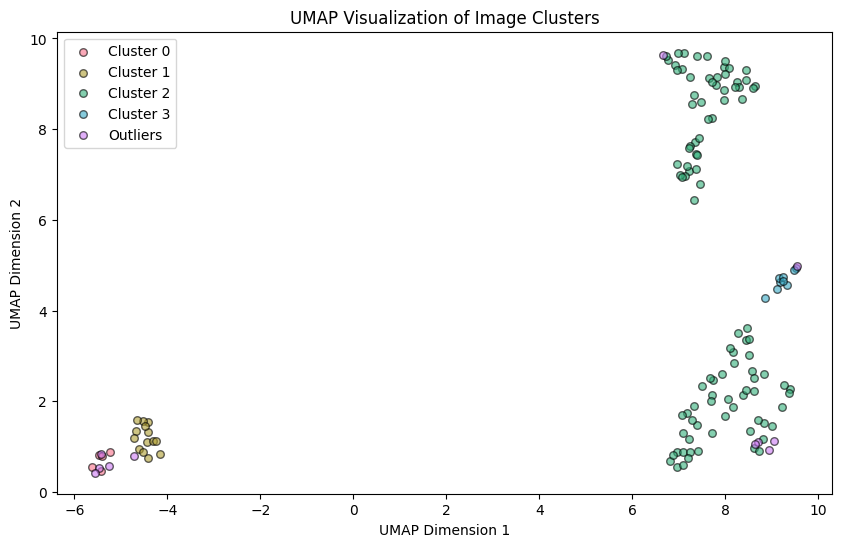

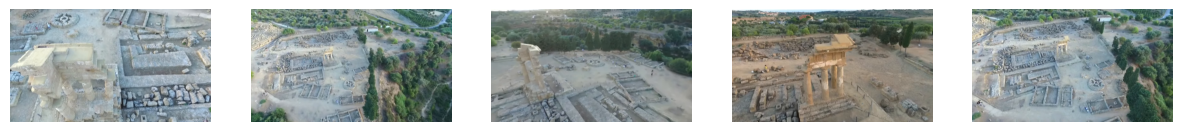

In [13]:
# Clustering example on specific datasets
dataset = "imc2024_dioscuri_baalshamin"
predictions = samples[dataset] 
images_dir = os.path.join(data_dir, 'train' if is_train else 'test', dataset)
image_paths = [os.path.join(images_dir, p.filename) for p in predictions]
if clip_option == 0:
    embeddings = get_global_descs(image_paths, device)
elif clip_option == 1:
    embeddings = get_dataset_embeddings(samples, dataset, concat_embeddings)
elif clip_option == 2:
    model_name = "openai/clip-vit-base-patch32"
    clip_model = CLIPModel.from_pretrained(model_name).to(device)
    processor = CLIPProcessor.from_pretrained(model_name)
    clip_model.eval()
    embeddings = get_image_embeddings(image_paths, clip_model, processor, device).cpu().numpy()
    
clusters, reduced_embeddings = cluster_images(embeddings)
visualize_clusters(reduced_embeddings, clusters, image_paths)

## Run COLMAP for Camera Pose Estimation

In [21]:
# Code adapted from Octavi Grau https://www.kaggle.com/code/octaviograu/baseline-dinov2-aliked-lightglue
datasets_to_process = None #Run on all test datasets
if is_train:
    # Note: When running on the training dataset, the notebook will hit the time limit and die. Use this filter to run on a few specific datasets.
    datasets_to_process = [
    	# New data.
    	# 'amy_gardens',
    	# 'ETs',
    	# 'fbk_vineyard',
    	# 'stairs',
    	# Data from IMC 2023 and 2024.
        # 'imc2024_dioscuri_baalshamin',
    	# 'imc2023_theather_imc2024_church',
    	# 'imc2023_heritage',
    	# 'imc2023_haiper',
    	# 'imc2024_lizard_pond',
    	# Crowdsourced PhotoTourism data.
    	# 'pt_stpeters_stpauls',
    	# 'pt_brandenburg_british_buckingham',
    	# 'pt_piazzasanmarco_grandplace',
    	'pt_sacrecoeur_trevi_tajmahal',
    ]
    
timings = {
    "shortlisting":[],
    "feature_detection": [],
    "feature_matching":[],
    "RANSAC": [],
    "Reconstruction": [],
}
mapping_result_strs = []

start = 0
print (f"Extracting on device {device}")
for dataset, predictions in samples.items():
    if datasets_to_process and dataset not in datasets_to_process:
        print(f'Skipping "{dataset}"')
        continue
    
    images_dir = os.path.join(data_dir, 'train' if is_train else 'test', dataset)
    images = [os.path.join(images_dir, p.filename) for p in predictions]

    print(f'\nProcessing dataset "{dataset}": {len(images)} images')

    filename_to_index = {p.filename: idx for idx, p in enumerate(predictions)}

    feature_dir = os.path.join(workdir, 'featureout', dataset)
    os.makedirs(feature_dir, exist_ok=True)

    # Select the correct embeddings based on clip_option
    if clip_option == 1:
        embeddings = torch.tensor(get_dataset_embeddings(samples, dataset, concat_embeddings)).float()
    elif clip_option == 2:
        model_name = "openai/clip-vit-base-patch32"
        clip_model = CLIPModel.from_pretrained(model_name).to(device)
        processor = CLIPProcessor.from_pretrained(model_name)
        clip_model.eval()
        embeddings = get_image_embeddings(images, clip_model, processor, device).cpu().float()

    # Wrap algos in try-except blocks so we can populate a submission even if one scene crashes.
    try:
        t = time()
        index_pairs = get_image_pairs_shortlist(
            images,
            embeddings,
            sim_th = 0.3, # should be strict
            min_pairs = 20, # we should select at least min_pairs PER IMAGE with biggest similarity
            exhaustive_if_less = 20,
            device=device
        )
        timings['shortlisting'].append(time() - t)
        print (f'Shortlisting. Number of pairs to match: {len(index_pairs)}. Done in {time() - t:.4f} sec')
        gc.collect()
    
        t = time()

        detect_aliked(images, feature_dir, 4096, device=device)
        gc.collect()
        timings['feature_detection'].append(time() - t)
        print(f'Features detected in {time() - t:.4f} sec')
        
        t = time()
        match_with_lightglue(images, index_pairs, feature_dir=feature_dir, device=device, verbose=False)
        timings['feature_matching'].append(time() - t)
        print(f'Features matched in {time() - t:.4f} sec')

        database_path = os.path.join(feature_dir, 'colmap.db')
        if os.path.isfile(database_path):
            os.remove(database_path)
        gc.collect()
        sleep(1)
        import_into_colmap(images_dir, feature_dir=feature_dir, database_path=database_path)
        output_path = f'{feature_dir}/colmap_rec_aliked'
        
        t = time()
        pycolmap.match_exhaustive(database_path)
        timings['RANSAC'].append(time() - t)
        print(f'Ran RANSAC in {time() - t:.4f} sec')
        
        # By default colmap does not generate a reconstruction if less than 10 images are registered.
        # Lower it to 3.
        mapper_options = pycolmap.IncrementalPipelineOptions()
        mapper_options.min_model_size = 3
        mapper_options.max_num_models = 25
        os.makedirs(output_path, exist_ok=True)
        t = time()
        maps = pycolmap.incremental_mapping(
            database_path=database_path, 
            image_path=images_dir,
            output_path=output_path,
            options=mapper_options)
        sleep(1)
        timings['Reconstruction'].append(time() - t)
        print(f'Reconstruction done in  {time() - t:.4f} sec')
        print(maps)

        clear_output(wait=False)
    
        registered = 0
        for map_index, cur_map in maps.items():
            for index, image in cur_map.images.items():
                prediction_index = filename_to_index[image.name]
                predictions[prediction_index].cluster_index = map_index
                predictions[prediction_index].rotation = deepcopy(image.cam_from_world.rotation.matrix())
                predictions[prediction_index].translation = deepcopy(image.cam_from_world.translation)
                registered += 1
        mapping_result_str = f'Dataset "{dataset}" -> Registered {registered} / {len(images)} images with {len(maps)} clusters'
        mapping_result_strs.append(mapping_result_str)
        print(mapping_result_str)
        gc.collect()
    except Exception as e:
        print(e)
        # raise e
        mapping_result_str = f'Dataset "{dataset}" -> Failed!'
        mapping_result_strs.append(mapping_result_str)
        print(mapping_result_str)

print('\nResults')
for s in mapping_result_strs:
    print(s)

print('\nTimings')
for k, v in timings.items():
    print(f'{k} -> total={sum(v):.02f} sec.')

Dataset "pt_sacrecoeur_trevi_tajmahal" -> Registered 225 / 225 images with 3 clusters
Skipping "pt_stpeters_stpauls"
Skipping "amy_gardens"
Skipping "fbk_vineyard"
Skipping "ETs"
Skipping "stairs"

Results
Dataset "pt_sacrecoeur_trevi_tajmahal" -> Registered 225 / 225 images with 3 clusters

Timings
shortlisting -> total=0.02 sec.
feature_detection -> total=15.40 sec.
feature_matching -> total=346.55 sec.
RANSAC -> total=59.46 sec.
Reconstruction -> total=1323.51 sec.


## Save data to CSV and Evaluate

In [22]:
# Must Create a submission file.

array_to_str = lambda array: ';'.join([f"{x:.09f}" for x in array])
none_to_str = lambda n: ';'.join(['nan'] * n)

submission_file = '/kaggle/working/submission.csv'
with open(submission_file, 'w') as f:
    if is_train:
        f.write('dataset,scene,image,rotation_matrix,translation_vector\n')
        for dataset in samples:
            for prediction in samples[dataset]:
                cluster_name = 'outliers' if prediction.cluster_index is None else f'cluster{prediction.cluster_index}'
                rotation = none_to_str(9) if prediction.rotation is None else array_to_str(prediction.rotation.flatten())
                translation = none_to_str(3) if prediction.translation is None else array_to_str(prediction.translation)
                f.write(f'{prediction.dataset},{cluster_name},{prediction.filename},{rotation},{translation}\n')
    else:
        f.write('image_id,dataset,scene,image,rotation_matrix,translation_vector\n')
        for dataset in samples:
            for prediction in samples[dataset]:
                cluster_name = 'outliers' if prediction.cluster_index is None else f'cluster{prediction.cluster_index}'
                rotation = none_to_str(9) if prediction.rotation is None else array_to_str(prediction.rotation.flatten())
                translation = none_to_str(3) if prediction.translation is None else array_to_str(prediction.translation)
                f.write(f'{prediction.image_id},{prediction.dataset},{cluster_name},{prediction.filename},{rotation},{translation}\n')

!head {submission_file}

dataset,scene,image,rotation_matrix,translation_vector
imc2023_haiper,outliers,fountain_image_116.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_108.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_101.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_082.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_071.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_025.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_000.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_007.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_012.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan


In [23]:
old_df = pd.read_csv("/kaggle/input/old-submission/submission.csv")
new_df = pd.read_csv("/kaggle/working/submission.csv")
merged_df = pd.concat([old_df, new_df], ignore_index=True)

# Define a function to check if rotation_matrix or translation_vector are valid (not just 'nan;nan;...')
def has_valid_values(row):
    return not (row['rotation_matrix'].startswith('nan') or row['translation_vector'].startswith('nan'))

# Add a helper column that marks rows with valid values
merged_df['has_valid'] = merged_df.apply(has_valid_values, axis=1)

# Sort so that valid rows come first
merged_df = merged_df.sort_values('has_valid', ascending=False)

# Now drop duplicates, keeping the first (which will be the one with valid values)
merged_df = merged_df.drop_duplicates(subset=['image', 'dataset'], keep='first')
merged_df.drop('has_valid', axis=1, inplace=True)
merged_df = merged_df.sort_values('dataset')
merged_df.to_csv(submission_file, index=False)

In [24]:
# Download submission.csv
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv

In [25]:
if is_train:
    t = time()
    final_score, dataset_scores = metric.score(
        gt_csv='/kaggle/input/image-matching-challenge-2025/train_labels.csv',
        user_csv=submission_file,
        thresholds_csv='/kaggle/input/image-matching-challenge-2025/train_thresholds.csv',
        mask_csv=None if is_train else os.path.join(data_dir, 'mask.csv'),
        inl_cf=0,
        strict_cf=-1,
        verbose=True,
    )
    print(f'Computed metric in: {time() - t:.02f} sec.')

imc2023_haiper: score=63.15% (mAA=62.78%, clusterness=63.53%)
imc2023_heritage: score=51.49% (mAA=34.89%, clusterness=98.23%)
imc2023_theather_imc2024_church: score=57.14% (mAA=40.00%, clusterness=100.00%)
imc2024_dioscuri_baalshamin: score=67.08% (mAA=50.46%, clusterness=100.00%)
imc2024_lizard_pond: score=63.07% (mAA=46.26%, clusterness=99.06%)
pt_brandenburg_british_buckingham: score=67.19% (mAA=76.50%, clusterness=59.89%)
pt_piazzasanmarco_grandplace: score=88.56% (mAA=79.48%, clusterness=100.00%)
pt_sacrecoeur_trevi_tajmahal: score=91.05% (mAA=83.56%, clusterness=100.00%)
pt_stpeters_stpauls: score=0.00% (mAA=0.00%, clusterness=0.00%)
amy_gardens: score=22.72% (mAA=12.82%, clusterness=100.00%)
fbk_vineyard: score=14.88% (mAA=9.58%, clusterness=33.33%)
ETs: score=30.56% (mAA=23.08%, clusterness=45.24%)
stairs: score=5.36% (mAA=2.78%, clusterness=77.14%)
Average over all datasets: score=47.87% (mAA=40.17%, clusterness=75.11%)
Computed metric in: 1297.53 sec.
